# Sentiment & Thematic Analysis
Quantify review sentiment and identify themes to uncover satisfaction drivers and pain points.

### Import Libraries

In [66]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
#import dependencies
import pandas as pd

#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from src.sentiment_analysis import load_data, preprocess_text, get_textblob_sentiment, get_vader_sentiment, get_transformer_sentiment, analyze_sentiment, plot_sentiments, save_results, extract_keywords
from src.thematic_analysis import ThematicAnalyzer

## 1. Load & Preprocess Data

In [3]:
# Load cleaned review dataset
df = load_data('../data/clean/cleaned_reviews.csv')

# Apply preprocessing: lowercase, remove punctuation, stopwords, lemmatization
df['cleaned_review'] = df['review'].apply(preprocess_text)

## 2. Sentiment Analysis

### TextBlob

In [ ]:
df['textblob_sentiment'] = df['cleaned_review'].apply(get_textblob_sentiment)
sns.countplot(x='textblob_sentiment', data=df)

### VADAR

In [ ]:
df['vader_sentiment'] = df['cleaned_review'].apply(get_vader_sentiment)
sns.countplot(x='vader_sentiment', data=df)

### DistilBERT (transformer-based)

In [ ]:
df = get_transformer_sentiment(df, 'cleaned_review')
sns.countplot(x='transformer_sentiment', data=df)

### Analyze Sentiment

Device set to use cpu
/home/micha/Downloads/course/10-accademy/week-2/fintech-review-analytics/notebooks/../src/sentiment_analysis.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='textblob_sentiment', data=df, palette='Set2')
/home/micha/Downloads/course/10-accademy/week-2/fintech-review-analytics/notebooks/../src/sentiment_analysis.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=df, palette='Set1')
/home/micha/Downloads/course/10-accademy/week-2/fintech-review-analytics/notebooks/../src/sentiment_analysis.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

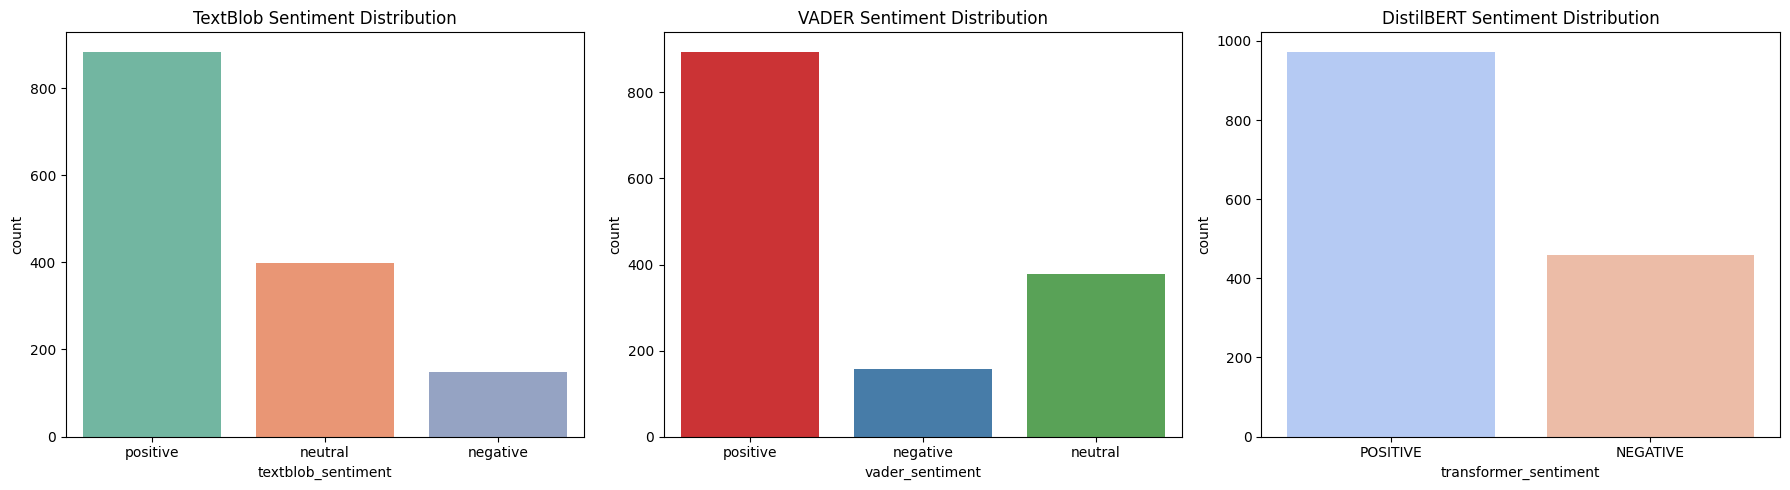

In [32]:
analyze_df = analyze_sentiment(df, 'cleaned_review')
## Plot sentiment distributions
plot_sentiments(analyze_df)

## 3. Aggregate Sentiment by Bank & Rating

In [33]:
agg = analyze_df.groupby(['bank', 'rating'])['transformer_score'].mean().reset_index()

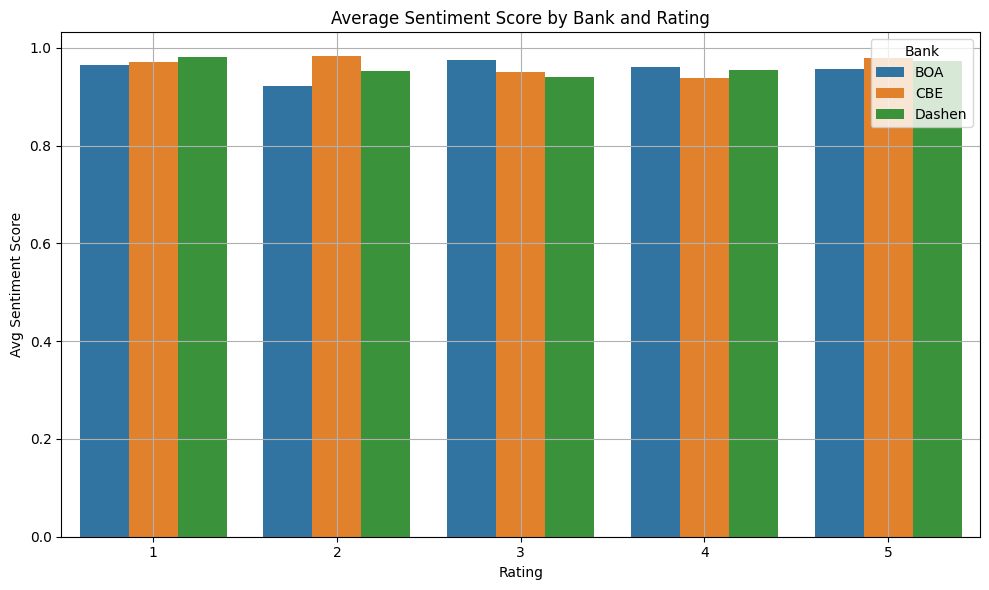

In [8]:
## Aggregate Sentiment by Bank and Rating distribution plot
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='transformer_score', hue='bank', data=agg)
plt.title("Average Sentiment Score by Bank and Rating")
plt.xlabel("Rating")
plt.ylabel("Avg Sentiment Score")
plt.legend(title='Bank')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Keyword Extraction (TF-IDF)
Extract Keywords Using TF-IDF
Identify the most representative words or phrases per bank.

In [73]:
df = load_data('../data/processed/review_sentiments.csv')
df.head()

,review,rating,date,bank,source,cleaned_review,textblob_sentiment,vader_sentiment,transformer_sentiment,transformer_score
0,really am happy to this app it is Siple to use...,5,2025-06-07,CBE,Google Play,really happy app siple use everything,positive,positive,POSITIVE,0.999789
1,I liked this app. But the User interface is ve...,2,2025-06-07,CBE,Google Play,liked app user interface basic attractive,positive,positive,POSITIVE,0.999667
2,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,CBE,Google Play,atm support transfer like country kenya nigeri...,neutral,positive,NEGATIVE,0.831325
3,what is this app problem???,1,2025-06-05,CBE,Google Play,app problem,neutral,negative,NEGATIVE,0.999191
4,the app is proactive and a good connections.,5,2025-06-05,CBE,Google Play,app proactive good connection,positive,positive,POSITIVE,0.999832


In [75]:
# Prepare and compute TF-IDF
analyzer = ThematicAnalyzer(df)
analyzer.clean_data()
analyzer.compute_tfidf()

#### Identify Top Keywords Per Bank

In [83]:
keywords = analyzer.extract_top_keywords_per_bank()
print(keywords)


🔑 Top Keywords for CBE:
good, app, best, nice, cbe, good app, like, best app, ok, excellent

🔑 Top Keywords for Dashen:
app, good, best, dashen, super, banking, dashen bank, wow, nice, amazing

🔑 Top Keywords for BOA:
app, good, work, boa, best, nice, worst, working, ok, banking
{'CBE': ['good', 'app', 'best', 'nice', 'cbe', 'good app', 'like', 'best app', 'ok', 'excellent'], 'Dashen': ['app', 'good', 'best', 'dashen', 'super', 'banking', 'dashen bank', 'wow', 'nice', 'amazing'], 'BOA': ['app', 'good', 'work', 'boa', 'best', 'nice', 'worst', 'working', 'ok', 'banking']}


#### Cluster Keywords Into Manual Themes

In [46]:
keyword_theme_map = {
    'login': 'Account Access',
    'password': 'Account Access',
    'transfer': 'Transaction Issues',
    'delay': 'Transaction Issues',
    'update': 'App Functionality',
    'crash': 'App Functionality',
    'support': 'Customer Service',
    'slow': 'Performance',
    'balance': 'Account Info',
    'UI': 'User Experience'
}


#### Assign themes to reviews

In [77]:
analyzer.assign_themes()
theme_dist = analyzer.get_theme_distribution()

#### Save & Export review sentiment

In [80]:
analyzer.save_results()

## Theme Distribution Plots Per Bank

In [81]:
theme_counts_total = analyzer.df['theme'].value_counts()
print("🔢 Theme Assignment Count:")
print(theme_counts_total)

🔢 Theme Assignment Count:
theme
Other                 1243
App Functionality       47
Transaction Issues      41
User Experience         30
Performance             25
Account Access          13
Customer Service         7
Account Info             1
Name: count, dtype: int64


#### Count Themes by Bank

In [86]:
# Count number of reviews per theme per bank
theme_counts_per_bank = analyzer.get_theme_distribution()

# Pivot for readability
theme_pivot = theme_counts_per_bank.pivot(index='theme', columns='bank', values='count').fillna(0).astype(int)

# Display as table
print("📊 Theme Counts per Bank:")
display(theme_pivot)

📊 Theme Counts per Bank:


bank,BOA,CBE,Dashen
theme,,,
Account Access,9,0,4
Account Info,1,0,0
App Functionality,27,12,8
Customer Service,1,2,4
Other,418,437,388
Performance,14,2,9
Transaction Issues,9,17,15
User Experience,6,6,18


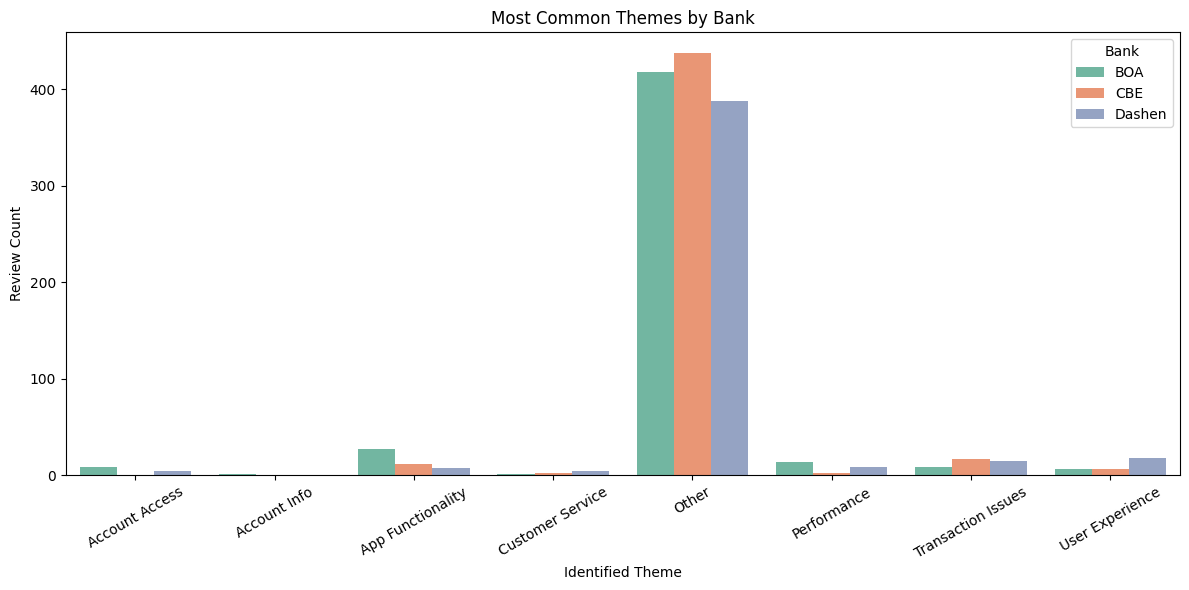

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count themes per bank
theme_counts = analyzer.df.groupby(['bank', 'theme']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=theme_counts, x='theme', y='count', hue='bank', palette='Set2')
plt.title("Most Common Themes by Bank")
plt.xlabel("Identified Theme")
plt.ylabel("Review Count")
plt.xticks(rotation=30)
plt.legend(title='Bank')
plt.tight_layout()
plt.show()


### 🔍 Thematic Analysis Summary

We extracted keywords from user reviews using TF-IDF and mapped them to core themes such as:

- **Account Access**: login, password, OTP issues
- **Transaction Issues**: transfer delays, failed payments
- **App Functionality**: crashes, bugs, versioning problems
- **Customer Support**: help responsiveness, service quality
- **User Experience**: UI design, speed, and layout

The plot above shows that:
- CBE users report **transaction and app functionality issues** more frequently.
- BOA users often mention **account access, performance issues**.
- Dashen users highlight **Transaction and app functionality issues** most.

#### Key Insights:
- **CBE**: Users most frequently report Transaction Issues (17 mentions).
- **BOA**: Stands out with more app functionality issues, Account Access (login/password) problems and high reports of Performance concerns.
- **Dashen**: Users highlight issues with transaction, App Functionality (bugs, crashes), and also mention slow performance.

While over 90% of reviews fall under “Other” due to general praise, the remaining ~10% give us clear signals about operational pain points that banks can act on.

These themes can help each bank prioritize technical and service improvements.

## 5. Visualizations

### Visualize Sentiment Distribution

<string>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



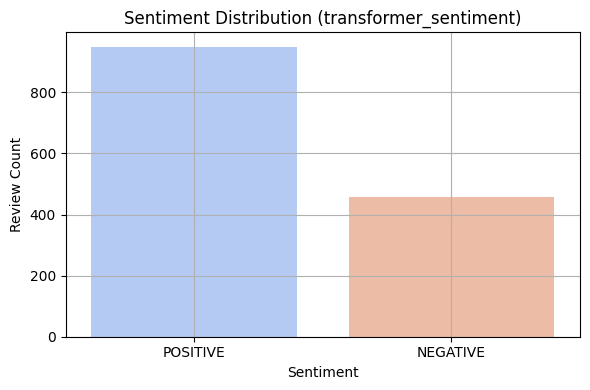

In [90]:
# Visualize sentiment distribution
analyzer.plot_sentiment_distribution('transformer_sentiment')

## Combining Sentiment Analysis and Keyword Extraction
Analyze keywords in positive vs. negative reviews to understand user preferences and issues.

In [96]:
# Extract and plot keywords for positive and negative reviews
positive_keywords = analyzer.extract_keywords_by_sentiment('transformer_sentiment', 'POSITIVE')
negative_keywords = analyzer.extract_keywords_by_sentiment('transformer_sentiment', 'NEGATIVE')

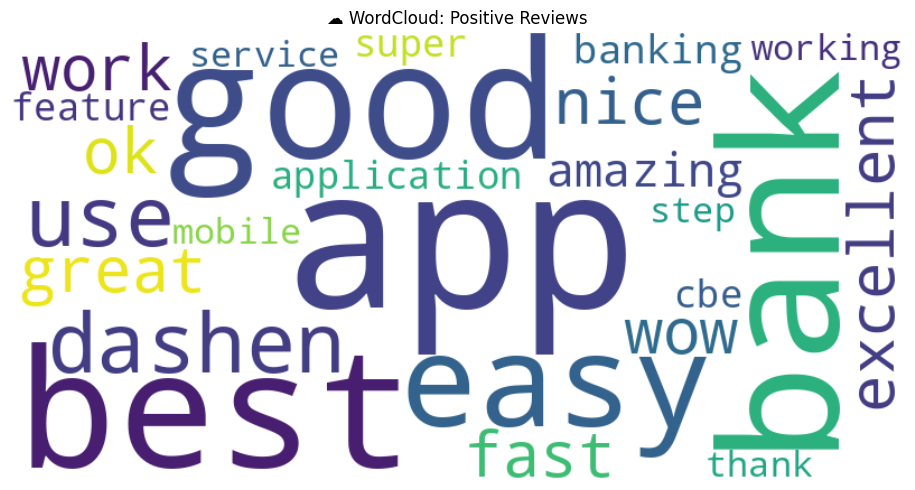

In [98]:
# Word cloud for positive reviews
analyzer.plot_wordcloud(positive_keywords, "☁️ WordCloud: Positive Reviews")

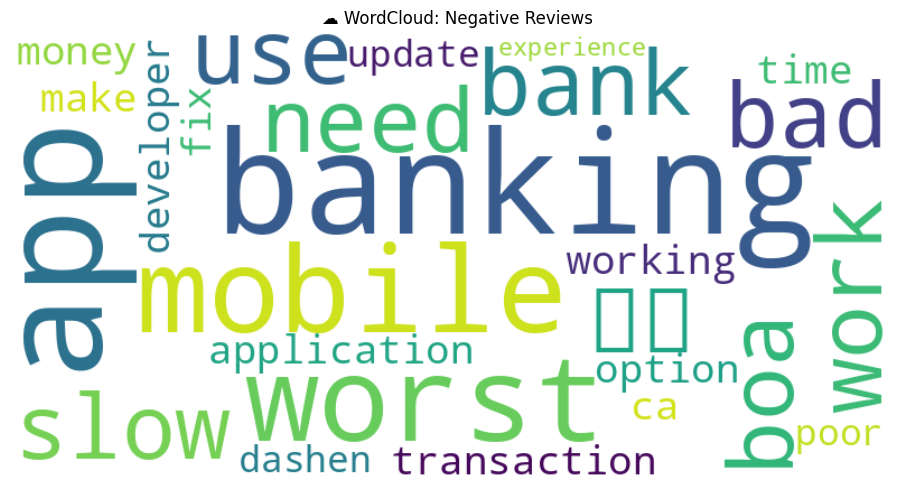

In [99]:
# Word cloud for negative reviews
analyzer.plot_wordcloud(negative_keywords, "☁️ WordCloud: Negative Reviews")